In [1]:
%pylab inline
import time
start_time = time.time()
from scipy.integrate import odeint
import numpy as np
from numpy.linalg import inv
from qutip import *
from numpy import linalg as LA
import scipy.integrate as integrate

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, 'white'),(0.1, 'blue'),
                                                        (0.3,'green'),(0.4, 'yellow'),
                                                    (0.6,'brown'),(1.0,'white')],N=256)

cmapnew = LinearSegmentedColormap.from_list('mycmap', [(0, 'white'),(0.25, 'blue'),
                                                    (0.5,'green'),(0.75, 'yellow'),
                                                    (1.0,'brown')],N=256)

In [3]:
#Global constants
hbar = 1.054*1e-25         #Planck's constant
k_b = 1.38*1e-23           #Boltzmann constant
x = k_b*4/hbar             #Used to compute average number of bath excitations at bath temperature = 4K
#System parameters
Np = 15                         #Number of phonon states - Np dimensional harmonic oscillator
w_m = 2*np.pi                   #Mechanical resonator mode frequency = 2pi*1 GHz - all frequencies normalized in units of 1e9
d = np.linspace(0,2*w_m,30)     
det = getattr(d, "tolist", lambda: d)()  #Energy splitting between |x> and |y> = 1 GHz - Cooling rate is plotted as a function of this (y-axis)
lam = 2*np.pi*5e-3                 #Coupling constant lambda = 2pi*5 MHz
lam_0 = 0                             
lam_par = lam
lam_perp = lam                      #Values of coupling constants taken from paper
gamma = 2*np.pi*15e-3               #NV center decay rate = 2pi*15 MHz
kappa = 2*np.pi*1e-6                #Nanomechanical resonator decay rate = 2pi*1 kHz
n_th_p = n_thermal(w_m,x)           #Average number of bath phonons at temperature = 4K
omega = 5*gamma                     #Laser Rabi frequency
delta1 = np.linspace(-1.2*w_m,1.2*w_m,30)
delta2 = getattr(delta1, "tolist", lambda: delta1)()   #Laser detuning - Cooling rate is plotted as a function of this (x-axis)
n_th_p                              #Print equilibrium phonon occupation number for support temperature T

82.8534936830278

In [5]:
#NV operators
Identity = qeye(3)
Sigx = jmat(1,'x')
Sigy = jmat(1,'y')
Sigz = jmat(1,'z')

ketg = tensor(qeye(Np), fock(3,0))
kety = tensor(qeye(Np), fock(3,1))
ketx = tensor(qeye(Np), fock(3,2))

sig_0 = ketx*ketx.dag() + kety*kety.dag()
sig_par = ketx*ketx.dag() - kety*kety.dag()
sig_perp = ketx*kety.dag() + kety*ketx.dag()
sig = (lam_0*sig_0) + (lam_par*sig_par) + (lam_perp*sig_perp)
X = ketg*ketx.dag()
Y = ketg*kety.dag()

#Mechanical resonator operators
a = tensor(destroy(Np), qeye(3))
num_a = a.dag()*a

#Collapse operators
c_op_list = []

rate = kappa * (1 + n_th_p)
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a)

rate = kappa * n_th_p
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a.dag())

rate = gamma
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * X)
    
rate = gamma
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * Y)

In [6]:
Ham = np.zeros((Np*3,Np*3)) + 1j*np.zeros((Np*3,Np*3))
wlist = np.array([w_m])
Sp_full = []        #S(w_m)
Sm_full = []        #S(-w_m)
for i in range(len(det)):
    for j in range(len(delta2)):
        Ham = w_m*a.dag()*a - delta2[j]*(kety*kety.dag()) - (delta2[j]-det[i])*ketx*ketx.dag() + (omega/2)*(kety*ketg.dag() + ketg*kety.dag()) + lam_0*sig_0*(a+a.dag()) + lam_par*sig_par*(a+a.dag()) + lam_perp*sig_perp*(a+a.dag())
        Sp_full.append(spectrum(Ham,wlist,c_op_list,sig,sig,solver='pi'))       #Solver 'es' gives the same result
        Sm_full.append(spectrum(Ham,-wlist,c_op_list,sig,sig,solver='pi'))      #Solver 'pi' runs faster
    print i, '\n',

0 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 


In [20]:
#Cooling - Refer to paper, equation (16) onwards
crate = []
crate2 = []
N_0 = []
n_final = []                    
for i in range(len(det)):
    for j in range(len(delta2)):
        x = len(det)*i
        crate.append(2*(real(Sm_full[x+j]) - real(Sp_full[x+j]))/gamma) #Cooling rate

In [21]:
crate_final = np.array(crate).reshape(len(det),len(delta2)).transpose()

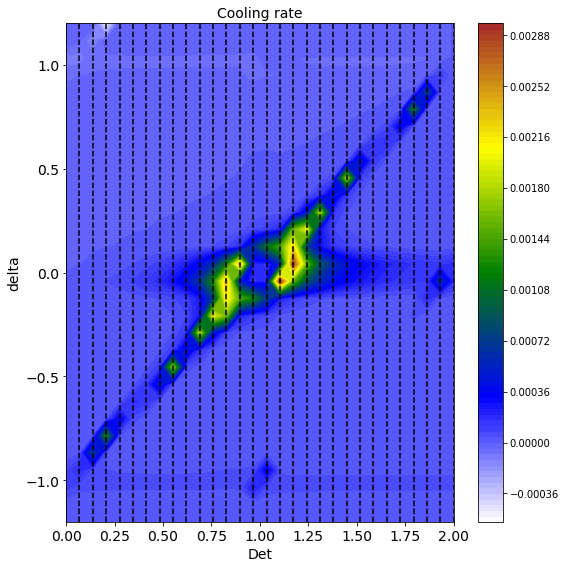

In [22]:
#30 x 30 resolution for the axes
[det_x,del_y]=meshgrid(linspace(det[0]/w_m,det[len(det)-1]/w_m,len(det)),linspace(delta2[0]/w_m,delta2[len(delta2)-1]/w_m,len(delta2)))    
fig,ax=subplots(1,1)
fig.set_size_inches(8,8)
cp1=ax.contourf(det_x,del_y,crate_final[:],101,cmap=cmapnew)
ax.plot(det_x,del_y,'--k')
fig.colorbar(cp1,ax=ax)
ax.set_xlim([det_x[0,0],det_x[len(det)-1,len(det)-1]])
ax.set_ylim([del_y[0,0],del_y[len(delta2)-1,len(delta2)-1]])
ax.set_xlabel('Det',fontsize=14)
ax.set_ylabel('delta',fontsize=14)
ax.set_title('Cooling rate',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout()